In [47]:
# first, we need to import our essentia module. It is aptly named 'essentia'!
import essentia

# as there are 2 operating modes in essentia which have the same algorithms,
# these latter are dispatched into 2 submodules:
import essentia.standard
import essentia.streaming
import os

In [12]:
# This is how the audio we want to process sounds like
import IPython
path = os.getcwd()
PA_path = "/PA/ASVspoof2019_PA_train/flac/"
file_path = "PA_T_0054000.flac"
full_path = path + PA_path + file_path
our_path = path + "/simple.wav"
# This is how the audio we want to process sounds like
import IPython
IPython.display.Audio(our_path)

In [36]:
# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename=full_path)

# and then we actually perform the loading:
audio = loader()

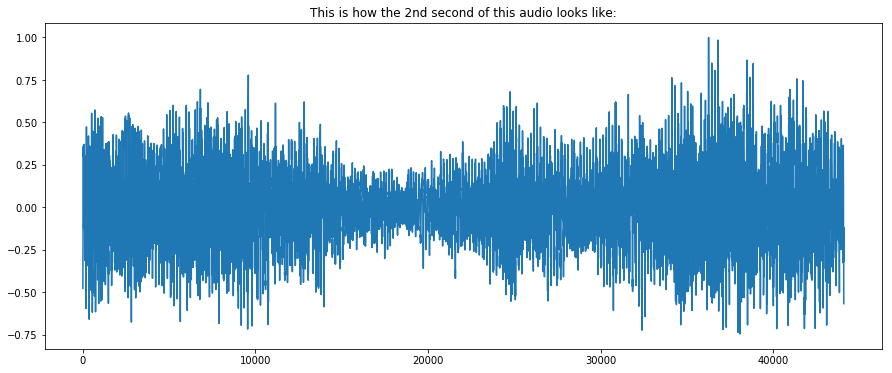

In [37]:
# pylab contains the plot() function, as well as figure, etc... (same names as Matlab)
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

plot(audio[1*44100:2*44100])
plt.title("This is how the 2nd second of this audio looks like:")
show() # unnecessary if you started "ipython --pylab"

In [38]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
mfcc = MFCC()

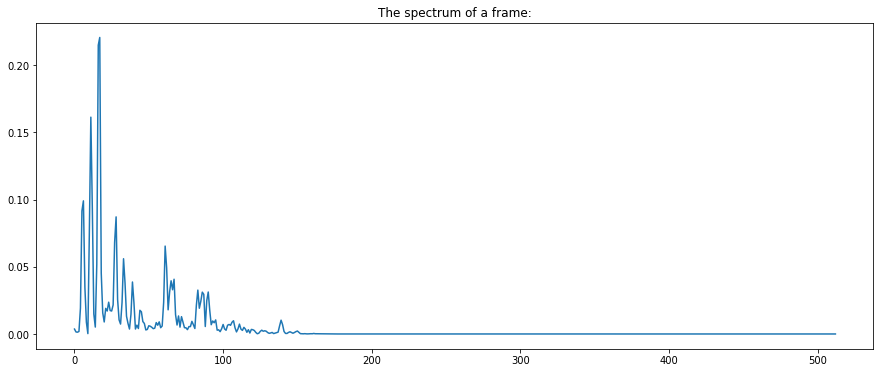

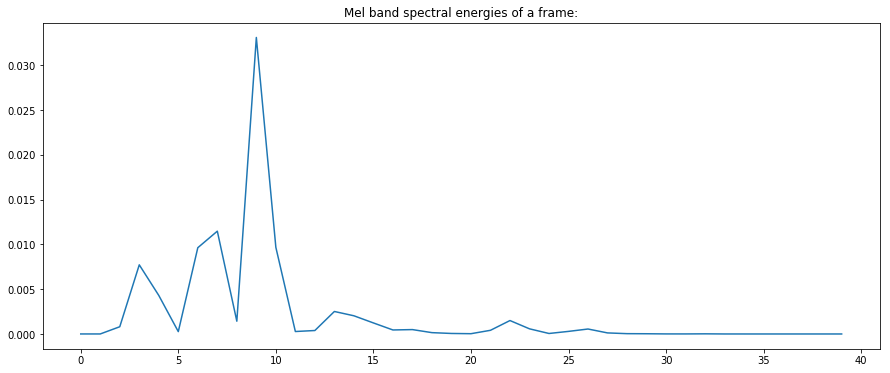

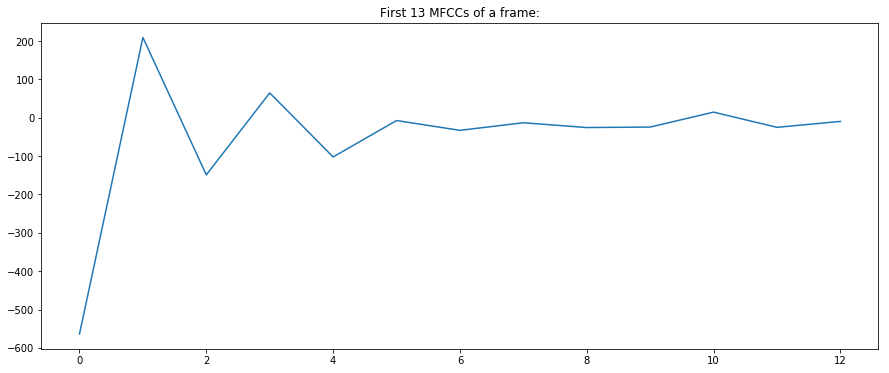

In [39]:
frame = audio[44100 : 44100 + 1024]
spec = spectrum(w(frame))
mfcc_bands, mfcc_coeffs = mfcc(spec)

plot(spec)
plt.title("The spectrum of a frame:")
show()

plot(mfcc_bands)
plt.title("Mel band spectral energies of a frame:")
show()

plot(mfcc_coeffs)
plt.title("First 13 MFCCs of a frame:")
show()

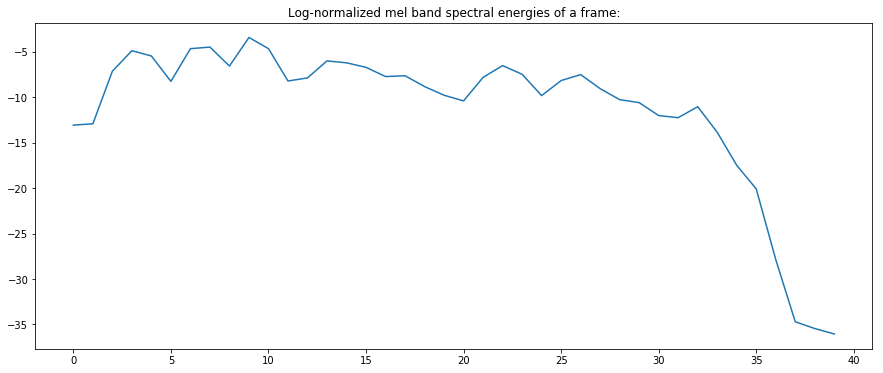

In [40]:
logNorm = UnaryOperator(type='log')
plot(logNorm(mfcc_bands))
plt.title("Log-normalized mel band spectral energies of a frame:")
show()

In [41]:
mfccs = []
melbands = []
frameSize = 1024
hopSize = 512

for fstart in range(0, len(audio)-frameSize, hopSize):
    frame = audio[fstart:fstart+frameSize]
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)
    melbands.append(mfcc_bands)

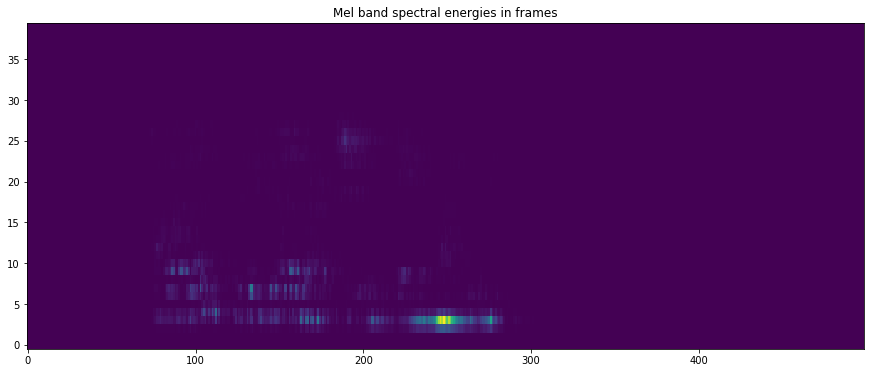

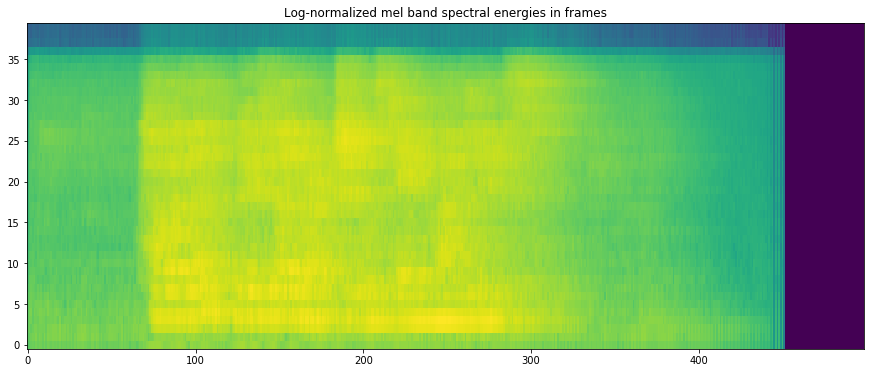

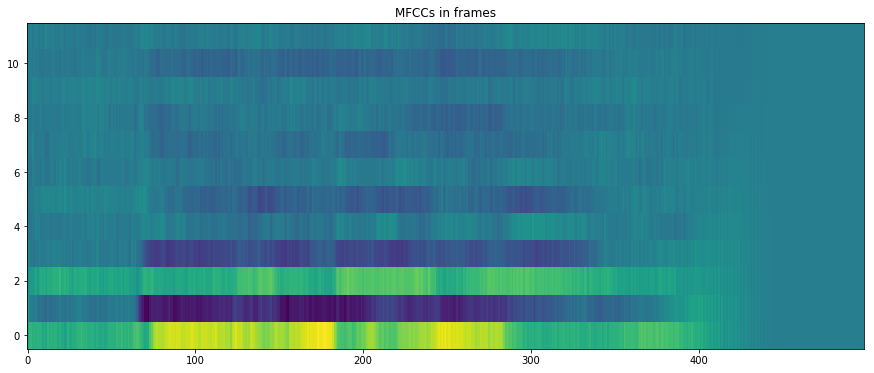

In [42]:
mfccs = []
melbands = []
melbands_log = []

for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)
    melbands.append(mfcc_bands)
    melbands_log.append(logNorm(mfcc_bands))

# transpose to have it in a better shape
# we need to convert the list to an essentia.array first (== numpy.array of floats)
mfccs = essentia.array(mfccs).T
melbands = essentia.array(melbands).T
melbands_log = essentia.array(melbands_log).T

# and plot
imshow(melbands[:,:], aspect = 'auto', origin='lower', interpolation='none')
plt.title("Mel band spectral energies in frames")
show()

imshow(melbands_log[:,:], aspect = 'auto', origin='lower', interpolation='none')
plt.title("Log-normalized mel band spectral energies in frames")
show()

imshow(mfccs[1:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("MFCCs in frames")
show()


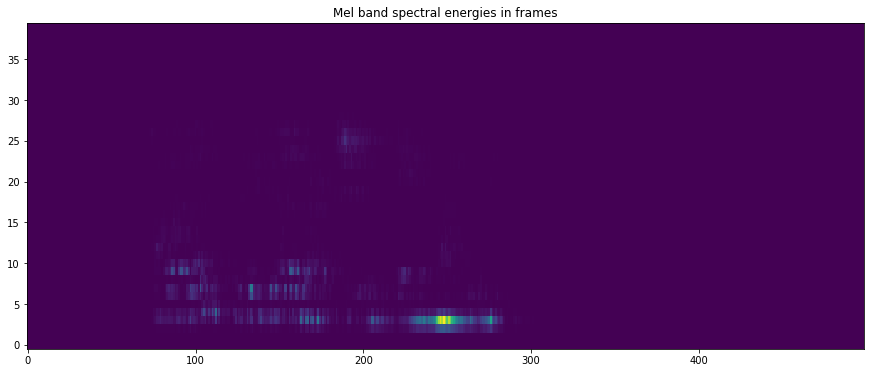

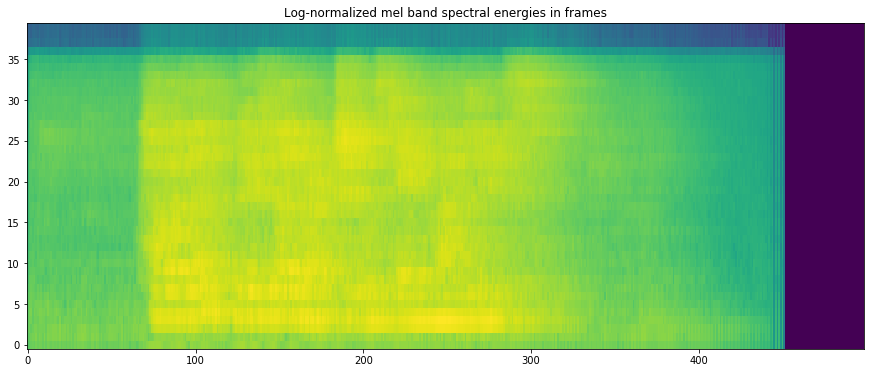

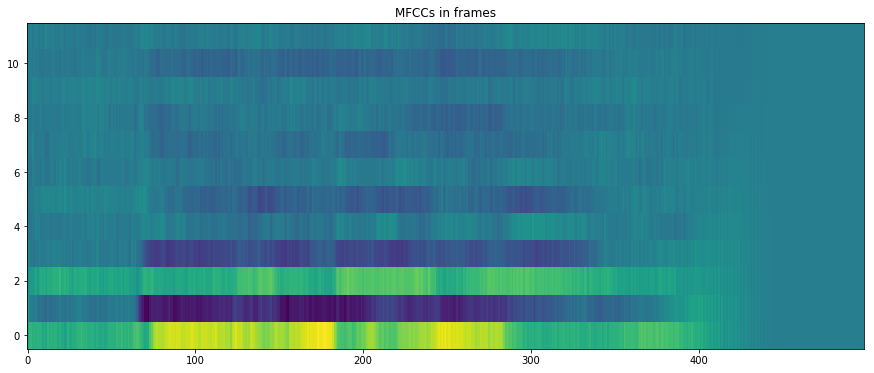

In [43]:
pool = essentia.Pool()

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512, startFromZero=True):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)
    pool.add('lowlevel.mfcc_bands', mfcc_bands)
    pool.add('lowlevel.mfcc_bands_log', logNorm(mfcc_bands))

imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', origin='lower', interpolation='none')
plt.title("Mel band spectral energies in frames")
show()

imshow(pool['lowlevel.mfcc_bands_log'].T, aspect = 'auto', origin='lower', interpolation='none')
plt.title("Log-normalized mel band spectral energies in frames")
show()

imshow(pool['lowlevel.mfcc'].T[1:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("MFCCs in frames")
show()

In [44]:
output = YamlOutput(filename = 'mfcc.sig') # use "format = 'json'" for JSON output
output(pool)

# or as a one-liner:
YamlOutput(filename = 'mfcc.sig')(pool)

In [45]:
# compute mean and variance of the frames
aggrPool = PoolAggregator(defaultStats = [ 'mean', 'stdev' ])(pool)

print('Original pool descriptor names:')
print(pool.descriptorNames())
print('')
print('Aggregated pool descriptor names:')
print(aggrPool.descriptorNames())
print('')

# and ouput those results in a file
YamlOutput(filename = 'mfccaggr.sig')(aggrPool)


Original pool descriptor names:
['lowlevel.mfcc', 'lowlevel.mfcc_bands', 'lowlevel.mfcc_bands_log']

Aggregated pool descriptor names:
['lowlevel.mfcc.mean', 'lowlevel.mfcc.stdev', 'lowlevel.mfcc_bands.mean', 'lowlevel.mfcc_bands.stdev', 'lowlevel.mfcc_bands_log.mean', 'lowlevel.mfcc_bands_log.stdev']

